# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [23]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [24]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [25]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [26]:
import torch

import numpy as np

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for a days in period 2011-01-01 to 2019-12-31 (9 years);

In [27]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [28]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2019-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

10



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (22330, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.265024,576145,ABEV3.SA,0
1,2011-01-03,31.500000,31.799999,31.379999,13.565920,3313400,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.708653,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.446309,10014663,ITUB4.SA,0
4,2011-01-03,9.264964,9.492898,9.264964,7.048941,3320493,LREN3.SA,0
...,...,...,...,...,...,...,...,...
22325,2019-12-30,30.549999,30.709999,30.150000,11.107358,22111600,PETR4.SA,0
22326,2019-12-30,6.780000,6.832000,6.570000,6.601397,8933500,PRIO3.SA,0
22327,2019-12-30,47.959999,48.290001,47.299999,44.469742,2701600,RENT3.SA,0
22328,2019-12-30,53.650002,53.860001,53.200001,37.320980,11928100,VALE3.SA,0


In [29]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2233,2233,2233,2233,2233,2233,2233
BBAS3.SA,2233,2233,2233,2233,2233,2233,2233
BBDC4.SA,2233,2233,2233,2233,2233,2233,2233
ITUB4.SA,2233,2233,2233,2233,2233,2233,2233
LREN3.SA,2233,2233,2233,2233,2233,2233,2233
PETR4.SA,2233,2233,2233,2233,2233,2233,2233
PRIO3.SA,2233,2233,2233,2233,2233,2233,2233
RENT3.SA,2233,2233,2233,2233,2233,2233,2233
VALE3.SA,2233,2233,2233,2233,2233,2233,2233


### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [30]:
df_portfolio = portfolio_raw_df[["date", "tic", "close", "high", "low"]]

environment = PortfolioOptimizationEnv(
        df_portfolio,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"]
    )

Normalizing ['close', 'high', 'low'] by previous time...


### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [31]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 4,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [32]:
DRLAgent.train_model(model, episodes=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 360894.34375
Final accumulative portfolio value: 3.6089434375
Maximum DrawDown: -0.4434476029949981
Sharpe ratio: 0.7866386386087141


  5%|▌         | 1/20 [00:22<07:00, 22.14s/it]

Initial portfolio value:100000
Final portfolio value: 392320.9375
Final accumulative portfolio value: 3.923209375
Maximum DrawDown: -0.4597560807522423
Sharpe ratio: 0.7987393449867807


 10%|█         | 2/20 [00:44<06:35, 22.00s/it]

Initial portfolio value:100000
Final portfolio value: 408955.0
Final accumulative portfolio value: 4.08955
Maximum DrawDown: -0.47531680854965064
Sharpe ratio: 0.793828844676633


 15%|█▌        | 3/20 [01:06<06:16, 22.14s/it]

Initial portfolio value:100000
Final portfolio value: 414569.9375
Final accumulative portfolio value: 4.145699375
Maximum DrawDown: -0.4699752450199851
Sharpe ratio: 0.8000691061367521


 20%|██        | 4/20 [01:29<05:58, 22.42s/it]

Initial portfolio value:100000
Final portfolio value: 419426.90625
Final accumulative portfolio value: 4.1942690625
Maximum DrawDown: -0.4568948485204819
Sharpe ratio: 0.804432807766576


 25%|██▌       | 5/20 [01:51<05:36, 22.41s/it]

Initial portfolio value:100000
Final portfolio value: 420542.3125
Final accumulative portfolio value: 4.205423125
Maximum DrawDown: -0.45954952945096905
Sharpe ratio: 0.7939898248991043


 30%|███       | 6/20 [02:14<05:14, 22.43s/it]

Initial portfolio value:100000
Final portfolio value: 445530.09375
Final accumulative portfolio value: 4.4553009375
Maximum DrawDown: -0.4898957687409402
Sharpe ratio: 0.7606043281638888


 35%|███▌      | 7/20 [02:36<04:50, 22.35s/it]

Initial portfolio value:100000
Final portfolio value: 424459.875
Final accumulative portfolio value: 4.24459875
Maximum DrawDown: -0.5413640716136647
Sharpe ratio: 0.6603770132343453


 40%|████      | 8/20 [02:58<04:27, 22.28s/it]

Initial portfolio value:100000
Final portfolio value: 374690.15625
Final accumulative portfolio value: 3.7469015625
Maximum DrawDown: -0.6056046504019357
Sharpe ratio: 0.5758127684803307


 45%|████▌     | 9/20 [03:20<04:04, 22.25s/it]

Initial portfolio value:100000
Final portfolio value: 386287.46875
Final accumulative portfolio value: 3.8628746875
Maximum DrawDown: -0.6475649807952853
Sharpe ratio: 0.5695910381716249


 50%|█████     | 10/20 [03:43<03:43, 22.32s/it]

Initial portfolio value:100000
Final portfolio value: 384588.6875
Final accumulative portfolio value: 3.845886875
Maximum DrawDown: -0.6673721268039015
Sharpe ratio: 0.5631584854492567


 55%|█████▌    | 11/20 [04:05<03:22, 22.45s/it]

Initial portfolio value:100000
Final portfolio value: 375858.8125
Final accumulative portfolio value: 3.758588125
Maximum DrawDown: -0.6818196477197169
Sharpe ratio: 0.5535247660723477


 60%|██████    | 12/20 [04:28<03:00, 22.55s/it]

Initial portfolio value:100000
Final portfolio value: 392846.78125
Final accumulative portfolio value: 3.9284678125
Maximum DrawDown: -0.6947301274454424
Sharpe ratio: 0.562105930758438


 65%|██████▌   | 13/20 [04:50<02:37, 22.49s/it]

Initial portfolio value:100000
Final portfolio value: 439958.84375
Final accumulative portfolio value: 4.3995884375
Maximum DrawDown: -0.7076008482721001
Sharpe ratio: 0.5875972093033132


 70%|███████   | 14/20 [05:13<02:15, 22.56s/it]

Initial portfolio value:100000
Final portfolio value: 484767.0625
Final accumulative portfolio value: 4.847670625
Maximum DrawDown: -0.7159634249556652
Sharpe ratio: 0.6088996170710405


 75%|███████▌  | 15/20 [05:36<01:53, 22.78s/it]

Initial portfolio value:100000
Final portfolio value: 531702.0625
Final accumulative portfolio value: 5.317020625
Maximum DrawDown: -0.7215960653093185
Sharpe ratio: 0.6291029864963561


 80%|████████  | 16/20 [05:59<01:30, 22.67s/it]

Initial portfolio value:100000
Final portfolio value: 580887.8125
Final accumulative portfolio value: 5.808878125
Maximum DrawDown: -0.7244367348644071
Sharpe ratio: 0.6485184394905196


 85%|████████▌ | 17/20 [06:21<01:07, 22.47s/it]

Initial portfolio value:100000
Final portfolio value: 636689.75
Final accumulative portfolio value: 6.3668975
Maximum DrawDown: -0.7250546456298861
Sharpe ratio: 0.6687845408392508


 90%|█████████ | 18/20 [06:44<00:45, 22.69s/it]

Initial portfolio value:100000
Final portfolio value: 703708.8125
Final accumulative portfolio value: 7.037088125
Maximum DrawDown: -0.724040746447379
Sharpe ratio: 0.6910666426229064


 95%|█████████▌| 19/20 [07:07<00:22, 22.78s/it]

Initial portfolio value:100000
Final portfolio value: 770829.875
Final accumulative portfolio value: 7.70829875
Maximum DrawDown: -0.723963800949291
Sharpe ratio: 0.7114060725942984


100%|██████████| 20/20 [07:30<00:00, 22.52s/it]


### Save Model

In [33]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Define test period
In this work, we are going to use three annual test periods: the year of 2020, 2021 and 2022. To get data from Yahoo Finance, we do just like in the training data.

In [34]:
portfolio_2020_raw_df = YahooDownloader(start_date = '2020-01-01',
                                end_date = '2020-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_2021_raw_df = YahooDownloader(start_date = '2021-01-01',
                                end_date = '2021-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_2022_raw_df = YahooDownloader(start_date = '2022-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (2480, 8)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (2470, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (2500, 8)


In [35]:
portfolio_2020_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,248,248,248,248,248,248,248
BBAS3.SA,248,248,248,248,248,248,248
BBDC4.SA,248,248,248,248,248,248,248
ITUB4.SA,248,248,248,248,248,248,248
LREN3.SA,248,248,248,248,248,248,248
PETR4.SA,248,248,248,248,248,248,248
PRIO3.SA,248,248,248,248,248,248,248
RENT3.SA,248,248,248,248,248,248,248
VALE3.SA,248,248,248,248,248,248,248


In [36]:
portfolio_2021_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,247,247,247,247,247,247,247
BBAS3.SA,247,247,247,247,247,247,247
BBDC4.SA,247,247,247,247,247,247,247
ITUB4.SA,247,247,247,247,247,247,247
LREN3.SA,247,247,247,247,247,247,247
PETR4.SA,247,247,247,247,247,247,247
PRIO3.SA,247,247,247,247,247,247,247
RENT3.SA,247,247,247,247,247,247,247
VALE3.SA,247,247,247,247,247,247,247


In [37]:
portfolio_2022_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,250,250,250,250,250,250,250
BBAS3.SA,250,250,250,250,250,250,250
BBDC4.SA,250,250,250,250,250,250,250
ITUB4.SA,250,250,250,250,250,250,250
LREN3.SA,250,250,250,250,250,250,250
PETR4.SA,250,250,250,250,250,250,250
PRIO3.SA,250,250,250,250,250,250,250
RENT3.SA,250,250,250,250,250,250,250
VALE3.SA,250,250,250,250,250,250,250


### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [38]:
df_portfolio_2020 = portfolio_2020_raw_df[["date", "tic", "close", "high", "low"]]
df_portfolio_2021 = portfolio_2021_raw_df[["date", "tic", "close", "high", "low"]]
df_portfolio_2022 = portfolio_2022_raw_df[["date", "tic", "close", "high", "low"]]

environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

Normalizing ['close', 'high', 'low'] by previous time...
Normalizing ['close', 'high', 'low'] by previous time...
Normalizing ['close', 'high', 'low'] by previous time...


### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [39]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(k_size= 4, time_window= 50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 96927.3828125
Final accumulative portfolio value: 0.969273828125
Maximum DrawDown: -0.36764619455052716
Sharpe ratio: 0.19808085830397928
Initial portfolio value:100000
Final portfolio value: 41994.1171875
Final accumulative portfolio value: 0.419941171875
Maximum DrawDown: -0.5922348828124999
Sharpe ratio: -3.254861565094857
Initial portfolio value:100000
Final portfolio value: 58763.44140625
Final accumulative portfolio value: 0.5876344140625
Maximum DrawDown: -0.4787706627114482
Sharpe ratio: -1.9011716966476102


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [40]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 403055.75
Final accumulative portfolio value: 4.0305575
Maximum DrawDown: -0.4787524774370584
Sharpe ratio: 0.785309068256786
Initial portfolio value:100000
Final portfolio value: 171126.875
Final accumulative portfolio value: 1.71126875
Maximum DrawDown: -0.250802109375
Sharpe ratio: 1.712444200902883
Initial portfolio value:100000
Final portfolio value: 95723.8984375
Final accumulative portfolio value: 0.957238984375
Maximum DrawDown: -0.172931698918652
Sharpe ratio: -0.1558501822517264
Initial portfolio value:100000
Final portfolio value: 114157.6015625
Final accumulative portfolio value: 1.141576015625
Maximum DrawDown: -0.16239860740097034
Sharpe ratio: 0.8449148548501653


### Plot graphics

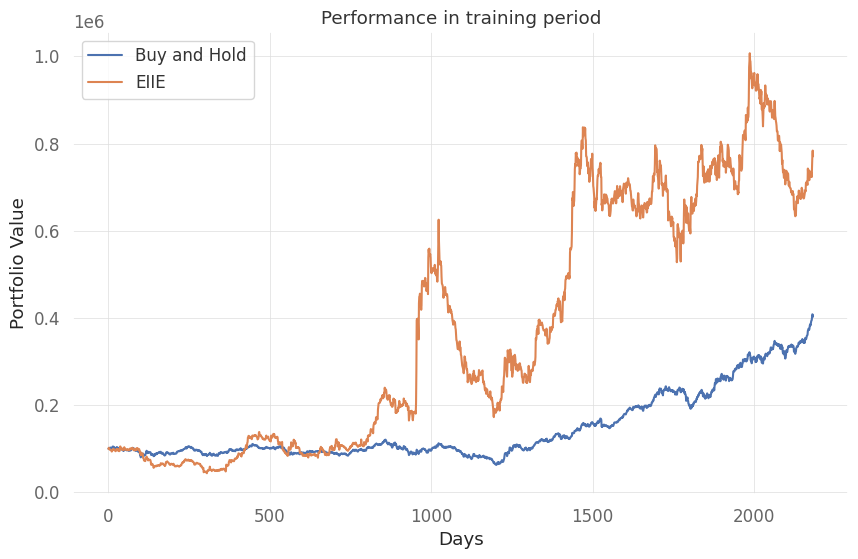

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

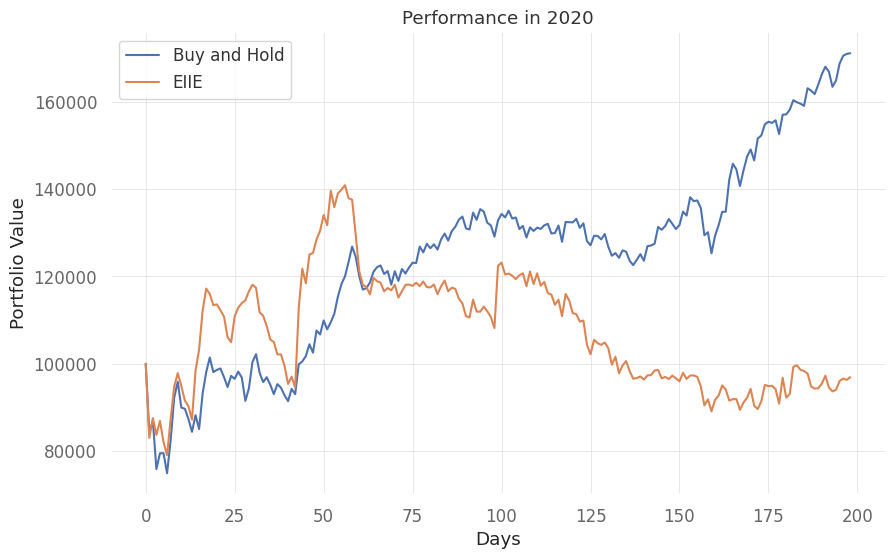

In [42]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

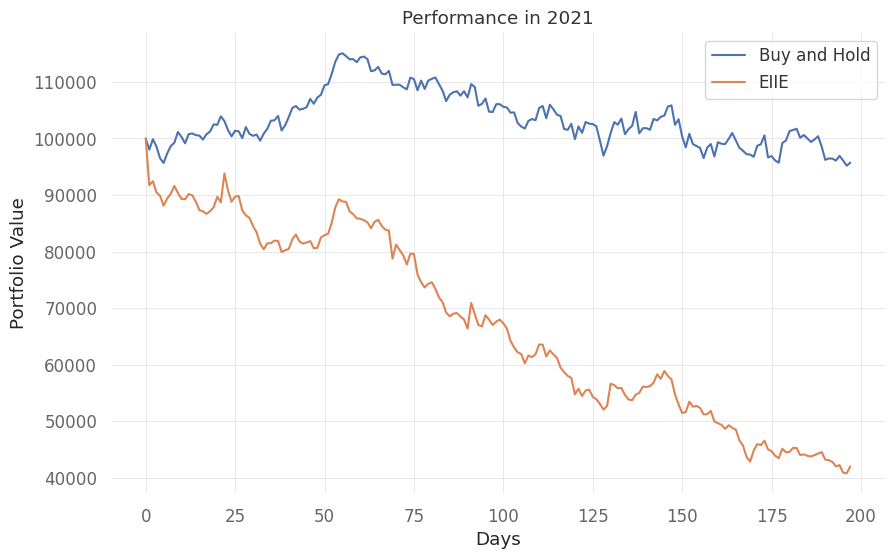

In [43]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

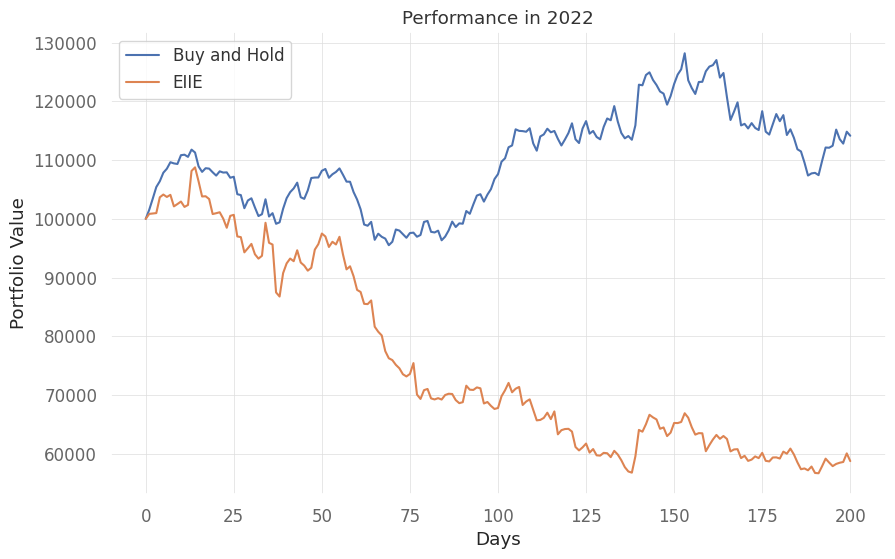

In [44]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

We can see that the agent is clearly overfitting, since it achieves great results in training period but is mediocre in testing periods. This is a common problem in this policy gradient algorithm. To deal with this, you can change the hyperparameters.